**Connexion à Google Drive pour accéder a la Dataset**

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importation des bibliothèques nécessaires**


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
import warnings

**Chemins et paramètres de base**


In [21]:
dataset_path = '/content/drive/My Drive/Dataset/Dataset'
output_image_size = (224, 224)  # Taille des images (hauteur, largeur)
batch_size = 32  # Taille des batchs

**Générateur de données pour l'augmentation d'images**


In [22]:
# Générateur de données avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalisation des pixels entre 0 et 1
    rotation_range=20,  # Rotation aléatoire jusqu'à 20 degrés
    width_shift_range=0.2,  # Décalage horizontal jusqu'à 20%
    height_shift_range=0.2,  # Décalage vertical jusqu'à 20%
    shear_range=0.2,  # Cisaillement aléatoire
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Flip horizontal
    validation_split=0.2  # Fraction des données pour validation
)


**Générateur pour les données d'entraînement**

In [23]:
# Générateur pour les données d'entraînement
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=output_image_size,
    batch_size=batch_size,
    class_mode='categorical',  # 'categorical' pour classification multi-classes
    subset='training'  # Sous-ensemble d'entraînement
)

Found 13194 images belonging to 151 classes.


**Générateur pour les données de validation**

In [24]:
# Générateur pour les données de validation
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=output_image_size,
    batch_size=batch_size,
    class_mode='categorical',  # 'categorical' pour classification multi-classes
    subset='validation'  # Sous-ensemble de validation
)

# Affichage des classes détectées
print("Classes trouvées :", train_generator.class_indices)

Found 3216 images belonging to 151 classes.
Classes trouvées : {'Abra': 0, 'Aerodactyl': 1, 'Alakazam': 2, 'Arbok': 3, 'Arcanine': 4, 'Articuno': 5, 'Beedrill': 6, 'Bellsprout': 7, 'Blastoise': 8, 'Bulbasaur': 9, 'Butterfree': 10, 'Caterpie': 11, 'Chansey': 12, 'Charizard': 13, 'Charmander': 14, 'Charmeleon': 15, 'Clefable': 16, 'Clefairy': 17, 'Cloyster': 18, 'Cubone': 19, 'Dewgong': 20, 'Diglett': 21, 'Ditto': 22, 'Dodrio': 23, 'Doduo': 24, 'Dragonair': 25, 'Dragonite': 26, 'Dratini': 27, 'Drowzee': 28, 'Dugtrio': 29, 'Eevee': 30, 'Ekans': 31, 'Electabuzz': 32, 'Electrode': 33, 'Exeggcute': 34, 'Exeggutor': 35, "Farfetch'd": 36, 'Fearow': 37, 'Flareon': 38, 'Gastly': 39, 'Gengar': 40, 'Geodude': 41, 'Gloom': 42, 'Golbat': 43, 'Goldeen': 44, 'Golduck': 45, 'Golem': 46, 'Graveler': 47, 'Grimer': 48, 'Growlithe': 49, 'Gyarados': 50, 'Haunter': 51, 'Hitmonchan': 52, 'Hitmonlee': 53, 'Horsea': 54, 'Hypno': 55, 'Ivysaur': 56, 'Jigglypuff': 57, 'Jolteon': 58, 'Jynx': 59, 'Kabuto': 60, 'Kabu

**Visualisation de l'equilibrage des classes de notre dataset**

In [27]:
from sklearn.utils import class_weight
import numpy as np

# Calculer les poids pour chaque classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Méthode pour équilibrer
    classes=np.unique(train_generator.classes),  # Les classes présentes
    y=train_generator.classes  # Distribution des classes
)

# Convertir les poids en dictionnaire
class_weights = dict(enumerate(class_weights))
print("Class weights :", class_weights)


Class weights : {0: 1.820364238410596, 1: 1.016017249345449, 2: 1.5886815171583384, 3: 0.9708609271523179, 4: 0.7801561021759698, 5: 0.8737748344370861, 6: 0.8737748344370861, 7: 0.9497552548229197, 8: 0.8483250819777535, 9: 0.5984759139980041, 10: 0.6934720908230843, 11: 0.8166119948010151, 12: 0.910182119205298, 13: 1.0402081362346263, 14: 0.7103860442577936, 15: 0.8737748344370861, 16: 1.1202241467142129, 17: 1.2306687808973042, 18: 1.2135761589403973, 19: 0.740487147828039, 20: 1.0922185430463576, 21: 1.2849629918192442, 22: 1.2849629918192442, 23: 1.1650331125827815, 24: 1.4324177613722724, 25: 1.0402081362346263, 26: 0.891606973915394, 27: 1.1202241467142129, 28: 1.1650331125827815, 29: 1.1202241467142129, 30: 0.9497552548229197, 31: 0.9197629836179854, 32: 1.016017249345449, 33: 1.6181015452538632, 34: 0.9817694768956023, 35: 1.1807768032933597, 36: 1.1807768032933597, 37: 1.1060440942241596, 38: 0.8401681100356597, 39: 0.9197629836179854, 40: 0.9708609271523179, 41: 1.266340339

**Extraction d'un Batch pour l'Entraînement et le Test**

In [28]:
# Extraire un batch pour l'entraînement
x_train, y_train = next(train_generator)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

# Extraire un batch pour la validation
x_test, y_test = next(validation_generator)
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")



x_train shape: (32, 224, 224, 3), y_train shape: (32, 151)
x_test shape: (32, 224, 224, 3), y_test shape: (32, 151)


In [29]:
import numpy as np

# Récupération de plusieurs lots pour l'entraînement et la validation
num_batches = 20  # Augmenté de 5 à 20 pour inclure plus d'échantillons de toutes les classes
x_train_batches = []
y_train_batches = []
x_val_batches = []
y_val_batches = []

# Boucle pour récupérer les lots
for _ in range(num_batches):
    # Récupération d'un lot d'entraînement
    x_batch, y_batch = next(train_generator)
    x_train_batches.append(x_batch)
    y_train_batches.append(y_batch)

    # Récupération d'un lot de validation
    x_batch, y_batch = next(validation_generator)
    x_val_batches.append(x_batch)
    y_val_batches.append(y_batch)

# Concaténation des lots pour former les ensembles d'entraînement et de validation
x_train = np.concatenate(x_train_batches)
y_train = np.concatenate(y_train_batches)
x_test = np.concatenate(x_val_batches)
y_test = np.concatenate(y_val_batches)

# Maintenant, on peut procéder à la division train_test_split
from sklearn.model_selection import train_test_split
# Division des données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(
     x_train, y_train, test_size=0.2, random_state=42
 )

**CNN simple**

In [30]:
import tensorflow as tf

# Définition du modèle CNN
model = tf.keras.Sequential([
    # Entrée du modèle, taille des images (224, 224, 3)
    tf.keras.layers.Input(shape=(224, 224, 3)),  # Couche d'entrée spécifiant la taille de l'image d'entrée (224x224 pixels, 3 canaux couleur)

    # Première couche de convolution : 32 filtres, taille de filtre (5x5), activation ReLU
    tf.keras.layers.Conv2D(32, (5, 5), strides=1, padding='same', activation='relu'),
    # Extraction des caractéristiques locales avec 32 filtres de taille 5x5, "same" conserve la taille d'entrée.

    # Première couche de pooling : réduction de la taille (2x2)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Réduit les dimensions spatiales de moitié (224x224 -> 112x112), conserve les caractéristiques principales.

    # Deuxième couche de convolution : 64 filtres, taille de filtre (3x3), activation ReLU
    tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    # Ajout de 64 filtres pour capturer des caractéristiques plus complexes.

    # Deuxième couche de pooling : réduction de la taille (2x2)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Réduction supplémentaire des dimensions spatiales (112x112 -> 56x56).

    # Troisième couche de convolution : 128 filtres, taille de filtre (3x3), activation ReLU
    tf.keras.layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    # Capture des motifs plus complexes avec 128 filtres.

    # Troisième couche de pooling : réduction de la taille (2x2)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Réduction finale des dimensions spatiales (56x56 -> 28x28).

    # Couche Flatten : aplatissement des dimensions en un vecteur 1D
    tf.keras.layers.Flatten(),
    # Transforme la sortie 28x28x128 en un vecteur linéaire de 100352 pour la couche dense suivante.

    # Première couche dense (Fully Connected Layer) : 256 neurones, activation ReLU
    tf.keras.layers.Dense(256, activation='relu'),
    # Combine toutes les caractéristiques pour apprendre des motifs complexes.

    # Couche Dropout : désactivation aléatoire de 50% des neurones pour éviter le surapprentissage
    tf.keras.layers.Dropout(0.5),
    # Améliore la généralisation du modèle en désactivant des neurones de manière aléatoire.

    # Dernière couche dense : nombre de sorties égal au nombre de classes, activation softmax
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
    # Prédiction des probabilités pour chaque classe (classification multi-classes).
])


**Fonction Train :Entrainement du modele**

In [36]:
from tensorflow.keras.utils import to_categorical

def train_CNN(model, x_train, y_train, x_test, y_test):
    """
    Fonction pour entraîner et évaluer un modèle CNN.
    Arguments :
        - model : modèle CNN à entraîner
        - x_train : données d'entraînement (images sous forme de tenseurs)
        - y_train : labels d'entraînement (one-hot encoded ou entiers)
        - x_test : données de test (images sous forme de tenseurs)
        - y_test : labels de test (one-hot encoded ou entiers)
    Retourne :
        - history : historique d'entraînement (contient les métriques pour chaque époque)
        - test_loss : perte calculée sur l'ensemble de test
        - test_accuracy : précision calculée sur l'ensemble de test
    """

    # Étape 1 : Conversion des labels en one-hot encoding
    num_classes = model.output_shape[-1]  # Nombre de classes que le modèle doit prédire

    # Redimensionner y_train et y_test si nécessaire
    y_train = y_train.reshape(-1) # Redimensionner en tableau 1D avant l'encodage one-hot
    y_test = y_test.reshape(-1) # Redimensionner en tableau 1D avant l'encodage one-hot

    y_train = to_categorical(y_train, num_classes=num_classes)  # Encodage des labels d'entraînement
    y_test = to_categorical(y_test, num_classes=num_classes)  # Encodage des labels de test

    # Étape 2 : Compilation du modèle
    # Initialisation de l'optimiseur avec un taux d'apprentissage ajusté
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    # Compilation du modèle avec la fonction de perte et les métriques
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',  # Fonction de perte adaptée à une classification multi-classes
        metrics=['accuracy']  # Métrique pour suivre la précision pendant l'entraînement
    )

    print("\n=== Début de l'entraînement du modèle CNN ===\n")

    # Étape 3 : Entraînement du modèle
    # Le modèle apprend à partir des données d'entraînement et évalue sa performance sur une fraction de validation
    history = model.fit(
        x_train, y_train,  # Données d'entraînement
        epochs=20,  # Nombre d'époques (passages sur tout le dataset)
        batch_size=32,  # Nombre d'images traitées à chaque mise à jour des poids
        validation_split=0.2,  # Utiliser 20 % de x_train pour la validation
        verbose=2  # Niveau d'affichage des logs (2 = résumé par époque)
    )
    return history, test_loss, test_accuracy


In [37]:
history = train_CNN(model, x_train, y_train, x_test, y_test)



=== Début de l'entraînement du modèle CNN ===

Epoch 1/20
13/13 - 72s - 6s/step - accuracy: 0.9951 - loss: 0.0143 - val_accuracy: 0.9903 - val_loss: 0.1716
Epoch 2/20
13/13 - 67s - 5s/step - accuracy: 0.9976 - loss: 0.0049 - val_accuracy: 0.9903 - val_loss: 0.1185
Epoch 3/20
13/13 - 83s - 6s/step - accuracy: 0.9951 - loss: 0.0067 - val_accuracy: 0.9903 - val_loss: 0.1312
Epoch 4/20
13/13 - 82s - 6s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9903 - val_loss: 0.1540
Epoch 5/20
13/13 - 81s - 6s/step - accuracy: 0.9976 - loss: 0.0037 - val_accuracy: 0.9903 - val_loss: 0.1606
Epoch 6/20
13/13 - 85s - 7s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9903 - val_loss: 0.1715
Epoch 7/20
13/13 - 67s - 5s/step - accuracy: 1.0000 - loss: 2.6513e-04 - val_accuracy: 0.9903 - val_loss: 0.1819
Epoch 8/20
13/13 - 81s - 6s/step - accuracy: 1.0000 - loss: 6.1478e-04 - val_accuracy: 0.9903 - val_loss: 0.1968
Epoch 9/20
13/13 - 81s - 6s/step - accuracy: 1.0000 - loss: 9.8490e-05 -

**Évaluation du modèle sur l'ensemble de test**

In [38]:
print("\n=== Évaluation du modèle sur l'ensemble de test ===\n")

# Étape 4 : Évaluation finale sur les données de test
# Calcul de la perte et de la précision sur des données non vues (x_test et y_test)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Accuracy sur l'ensemble de test : {test_accuracy * 100:.2f}%")  # Affiche la précision finale
print(f"Perte sur l'ensemble de test : {test_loss:.4f}")  # Affiche la perte finale


=== Évaluation du modèle sur l'ensemble de test ===

4/4 - 6s - 1s/step - accuracy: 0.0078 - loss: 44.0573
Accuracy sur l'ensemble de test : 0.78%
Perte sur l'ensemble de test : 44.0573


**Sauvegarder le modèle final**


In [41]:

model.save('CNN Simple_modele_entraine.keras')
print("Le modèle a été sauvegardé sous le nom : NN Simple_modele_entraine.h5")

Le modèle a été sauvegardé sous le nom : NN Simple_modele_entraine.h5


**Visualisation des courbes de perte et d'accuracy**


In [52]:
def plot_training_curves(history):
    """
    Visualise les courbes de perte et de précision pour l'entraînement et la validation.

    Arguments :
        - history : historique de l'entraînement (souvent le premier élément du tuple).
    """
    # Extraction des données d'historique
    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    # Création des courbes de perte
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Perte Entraînement')
    plt.plot(val_loss, label='Perte Validation')
    plt.title('Courbe de Perte')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    # Création des courbes de précision
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Précision Entraînement')
    plt.plot(val_accuracy, label='Précision Validation')
    plt.title('Courbe de Précision')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    plt.tight_layout()
    plt.show()


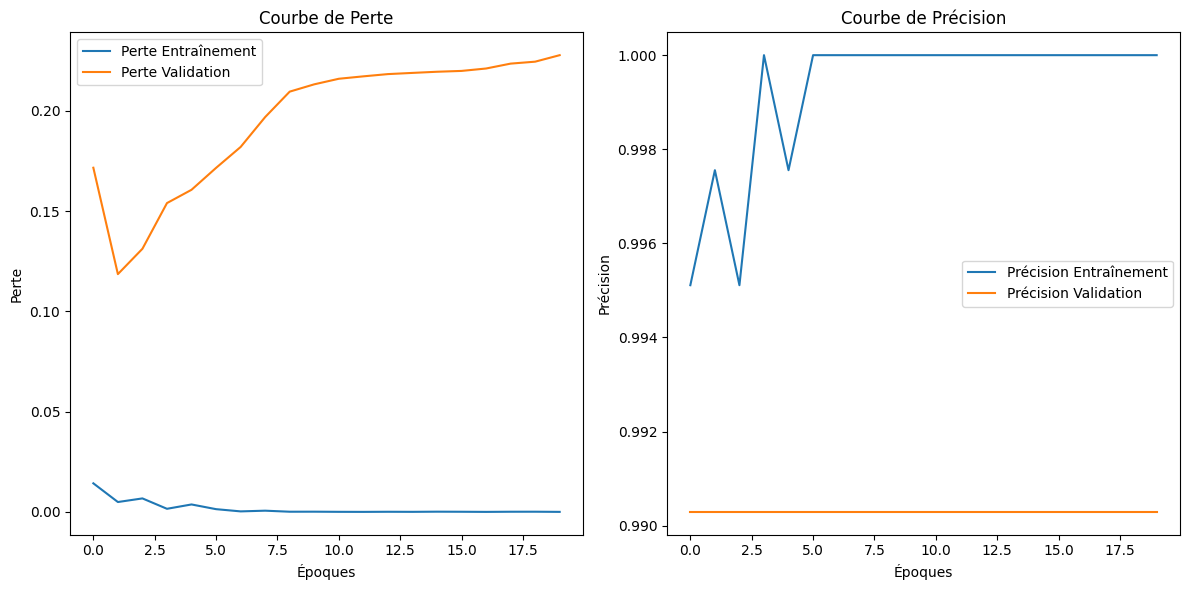

In [54]:
training_history: tf.keras.callbacks.History = history[0]
plot_training_curves(training_history.history)
